In [5]:
import numpy as np
import caffe

In [13]:
#init net
DATASET_DIR='../../dataset/cuhk03/cuhk03_release/data/'
EXP_NAME='./fullnet/'
MODEL_FILE = EXP_NAME+'test.prototxt'
PRETRAINED = EXP_NAME+'snapshot/model_iter_100000.caffemodel' 
model_name = EXP_NAME+PRETRAINED[PRETRAINED.rfind('_'):-11]

caffe.set_device(1)
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)

In [14]:
def evaluateCMC(gtLabels,predictLists):
    N=len(gtLabels)
    R=len(predictLists[0])
    histogram=np.zeros(N)
    meanAP=0.0
    for testIdx in range(N):
        #cmc and meanAP
        matched_num=0.0
        sum_precision=0.0
        for rankIdx in range(R):
            if predictLists[testIdx][rankIdx]==gtLabels[testIdx]:
                matched_num+=1.0
                sum_precision+=matched_num/(rankIdx+1)
                histogram[rankIdx]+=1
                break
        meanAP+=sum_precision
    #all
    cmc=np.cumsum(histogram)
    return cmc/N,meanAP/N

def readList(list_name,rand_seed,DATA_DIR=DATASET_DIR): 
    import random
    import os
    file_object = open(list_name)
    try:
        all_the_text = file_object.read()
    finally:
        file_object.close()

    lines = all_the_text.split('\n')
    #print all_the_text
    probes=[]
    gallerys=[]
    #make sure random keeps seems for all experiments
    random.seed(rand_seed+2015)
    for filename in lines:
        if filename!='' :
            campair_no = int(filename.split(',')[0])
            person_id = int(filename.split(',')[1])
            #print int(campair_no)
            while True:
                probe_no=random.randint(1,5)
                probe_filename = DATA_DIR +  'campair_%d/'%campair_no + \
                                '%02d_%04d_%02d.jpg'%(campair_no,person_id,probe_no)
                if os.path.isfile(probe_filename):
                    probes.append(probe_filename)
                    break
            while True:
                gallery_no=random.randint(6,10)  
                gallery_filename = DATA_DIR +  'campair_%d/'%campair_no + \
                                    '%02d_%04d_%02d.jpg'%(campair_no,person_id,gallery_no)
                if os.path.isfile(gallery_filename):
                    gallerys.append(gallery_filename)
                    break
    if len(probes)!=len(gallerys):
        print('something wrong! list length does not match!/n')
        return 0
    else:
        return probes,gallerys


def calCMC(net,set_no,rand_times=10,DATA_DIR=DATASET_DIR):
    list_dir=DATA_DIR[:-1]
    list_name=list_dir[:list_dir.rfind('/')+1]+'exp_set/set%02d_test_noval.txt'%(set_no)
    print list_name+'\n'
    #rand 10 times for stable result
    cmc_list=[]
    map_list=[]
    rand_seeds=range(rand_times)
    for i in range(rand_times):
        print 'Round %d with rand list:'%i
        probes,gallerys=readList(list_name,rand_seeds[i],DATA_DIR)
        scoreList,predictLists=generateScoreList(net,probes,gallerys)
        gtLabels=range(len(probes))
        cmc,mAP=evaluateCMC(gtLabels,predictLists)
        cmc_list.append(cmc)
        map_list.append(mAP)
        print cmc[0:5],mAP
    return np.average(cmc_list,axis=0),np.average(map_list,axis=0)

def getCVPRcmc():
    #return the cmc values, 100 dim vetor
    import numpy as np
    cmcIndex=[0,4,8,12,16,21,25,29,33,37,41,45,49,53]
    cmcOfCVPRImproved=[0.5474,0.8753,0.9293,0.9712,0.9764,0.9811,0.9899,0.9901,0.9912,0.9922,0.9937,0.9945,0.9951,1]
    pOfCVPRImproved = np.poly1d(np.polyfit(cmcIndex,cmcOfCVPRImproved,10))
    x_line=range(50)
    cmc=pOfCVPRImproved(x_line)
    return cmc

def plotCMC(cmcDict):
    import matplotlib.pyplot as plt
    get_ipython().magic(u'matplotlib inline')
    from matplotlib.legend_handler import HandlerLine2D
    import numpy as np

    #plot the cmc curve, record CVPR from the pdf paper.cmc[0,4,8,12,16,21,25,29,33,37,41,45,49]
    rank2show=20
    rankStep=4
    cmcIndex=np.arange(0,rank2show,rankStep)   #0,5,10,15,20,25

    colorList=['g','b','r','y','c','m','k']
    #start to plot
    plt.figure(figsize=(6,5),dpi=180)
    sortedCmcDict = sorted(cmcDict.items(), key=lambda (k, v): v[1])[::-1]
    for idx in range(len(sortedCmcDict)):
        cmc_dictList=sortedCmcDict[idx]
        cmc_name=cmc_dictList[0]
        cmc_list=cmc_dictList[1]
        #print cmc_name,": ",cmc_list
        #x for plot
        x_point=[item+1 for item in cmcIndex]
        x_line=range(rank2show)
        x_plot=[temp+1 for temp in x_line]
        #start plot
        plt.plot(x_plot, cmc_list[x_line],colorList[idx],label="%02.02f%% %s"%(100*cmc_list[0],cmc_name))
        plt.plot(x_point,cmc_list[cmcIndex],colorList[idx]+'*')
        #plt.legend(loc=4,handler_map={line: HandlerLine2D(numpoints=1)})
        #idx of color +1
        idx+=1
    #something to render
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.xticks(np.arange(0,rank2show+1,5))
    plt.yticks(np.arange(0.5,1.01,0.1))
    plt.grid()
    plt.legend(loc=4)
    plt.show()
    #end of show

In [34]:
N,C,H,W=net.blobs['data'].data.shape
h=5;w=5 #padding
transformer = caffe.io.Transformer({'data': (N,C,H+h*2,W+w*2)})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.array([ 104,  117,  123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

def readImages(images):
    imageLen=len(images)
    imageDataList=[]
    for imageIdx in range(imageLen):
        imageName=images[imageIdx]
        imageImage=transformer.preprocess('data', caffe.io.load_image(imageName))
        imageDataList.append(imageImage[:,h:h+H,w:w+W])
        imageIdx+=1
    #imageData and imageData
    imageData=np.asarray(imageDataList)
    return imageData
    
def generateScoreList(net,probes,gallerys):
    N,C,H,W=net.blobs['data'].data.shape
    from time import clock
    start=clock()
    #galleryData is same for each probe
    probeData=readImages(probes)
    galleryData=readImages(gallerys)
    
    net.blobs['data'].reshape(len(probes)+len(gallerys),C,H,W)
    net.blobs['data'].data[:len(probes),:] = probeData
    net.blobs['data'].data[len(probes):,:] = galleryData
    net.forward()
    
    scoreList=calcScoreList(net,len(probes))
    #we get scoreList, then cal predictLists
    predictLists=[]
    for score in scoreList:
        probeRankList=np.argsort(score)[::-1]
        predictLists.append(probeRankList)
    finish=clock()
    print('\r  Processing %dx%d pairs cost %f second time'%(len(probes),len(gallerys),(finish-start)))
    return scoreList,predictLists

def calcScoreList(net,len_probes):
    return calcEuclideanScoreList(net,len_probes)

def calcEuclideanScoreList(net,len_probes):
    scoreList=[]
    features_probe=net.blobs['normed_feature'].data[:len_probes,:]
    features_gallery=net.blobs['normed_feature'].data[len_probes:,:]
    features_probe=np.squeeze(features_probe)
    features_gallery=np.squeeze(features_gallery)
    for probeIdx in range(len_probes):
        cur_features=np.zeros(features_gallery.shape)
        cur_features[:]=features_probe[probeIdx,:]
        score_list_probe=euclideanScoreList(cur_features,features_gallery)
        scoreList.append(score_list_probe)
    return scoreList

def euclideanScoreList(feature1,feature2):
    #original shape (100,512,1,1), squeeze to (100,512)
    dist = np.sqrt(np.sum((feature1-feature2)**2,axis=1))
    similarScore=1.0/(1.0+dist)
    return similarScore.tolist()


In [35]:
#caculate CMC
set_no=1         #use set 1-10 for test (total 20)
cmc_list=[]
cmc,mAP=calCMC(net,set_no,rand_times=14)
cmc_list.append(cmc)
cmc_all=np.average(cmc_list,axis=0)
print('\nCMC from rank 1 to rank %d:'%(len(cmc_all)))
print(cmc_all[:60]),mAP

../../dataset/cuhk03/cuhk03_release/exp_set/set01_test_noval.txt

Round 0 with rand list:
  Processing 100x100 pairs cost 0.871851 second time
[ 0.8   0.88  0.9   0.94  0.96] 0.864565998329
Round 1 with rand list:
  Processing 100x100 pairs cost 0.797835 second time
[ 0.83  0.91  0.95  0.96  0.96] 0.892023809524
Round 2 with rand list:
  Processing 100x100 pairs cost 0.897465 second time
[ 0.75  0.91  0.92  0.95  0.96] 0.846909090909
Round 3 with rand list:
  Processing 100x100 pairs cost 0.903776 second time
[ 0.75  0.94  0.97  0.98  0.99] 0.859976190476
Round 4 with rand list:
  Processing 100x100 pairs cost 0.856634 second time
[ 0.89  0.95  0.95  0.95  0.97] 0.927083333333
Round 5 with rand list:
  Processing 100x100 pairs cost 0.887496 second time
[ 0.76  0.89  0.92  0.95  0.97] 0.849261904762
Round 6 with rand list:
  Processing 100x100 pairs cost 0.882732 second time
[ 0.79  0.9   0.93  0.96  0.97] 0.867289432789
Round 7 with rand list:
  Processing 100x100 pairs cost 0.805169 s

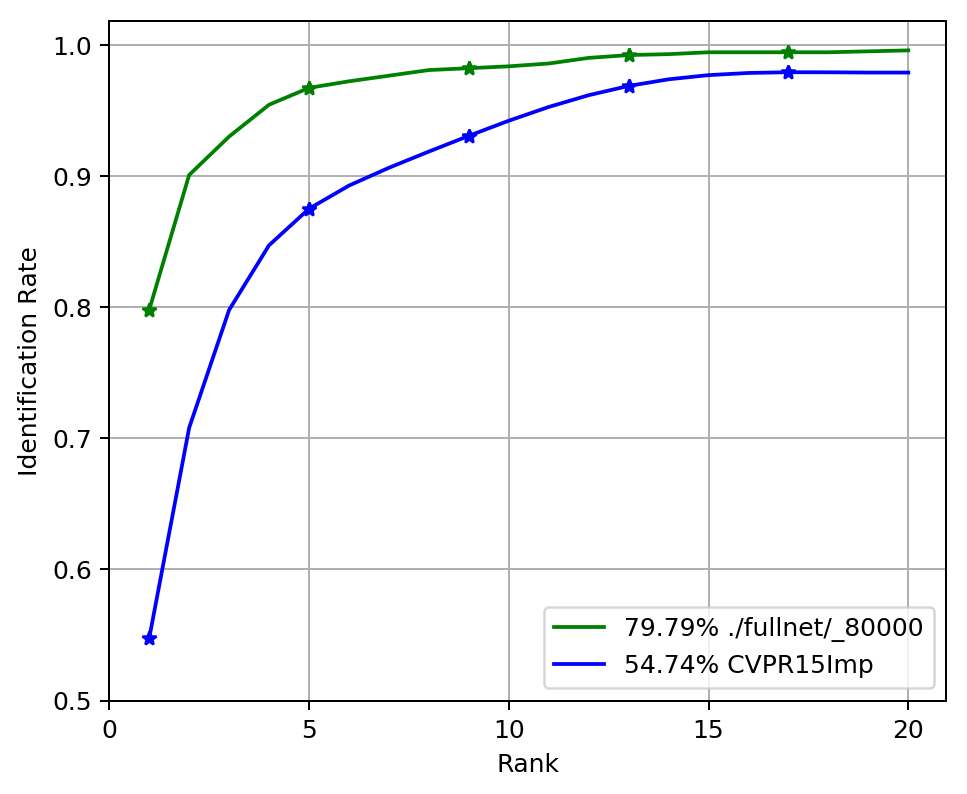

79.79	96.71	98.36	99.57; mAP:87.10


In [36]:
#dict of cmc, each value is a cmc list (at least 50 dim vetor, rank 1 to rank 50)
cmcDict={}
cmcDict['CVPR15Imp']=getCVPRcmc()
cmcDict[model_name]=cmc_all
#plot the dictionary, sorted by rank1 rate
plotCMC(cmcDict)
v=[c*100 for c in cmc_all]
print ('%.2f\t%.2f\t%.2f\t%.2f; mAP:%.2f'%(v[0],v[4],v[9],v[19],mAP*100))

In [37]:
# cmc_draw=[cmc_num0,cmc_num1,cmc_num2,cmc_num4,cmc_num8,cmc_num12]
# for cmc in cmc_draw:
#     print ('%.4f\t%.4f\t%.4f\t%.4f'%(cmc[0],cmc[4],cmc[9],cmc[19]))

In [8]:
fds

NameError: name 'fds' is not defined

In [ ]:
DATA_DIR=DATASET_DIR
list_dir=DATA_DIR[:-1]
list_name=list_dir[:list_dir.rfind('/')+1]+'exp_set/set%02d_test_noval.txt'%(set_no)
print list_name+'\n'
#rand 10 times for stable result
probes,gallerys=readList(list_name,1,DATA_DIR)
scoreList,predictLists=generateScoreList(net,probes,gallerys)
gtLabels=range(len(probes))
cmc,mAP=evaluateCMC(gtLabels,predictLists)
print cmc,mAP

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.rcParams['font.size']=0
plt.rcParams['axes.axisbelow']=False
plt.rcParams['xtick.major.width']=0
plt.rcParams['ytick.major.width']=0

import numpy as np

In [ ]:
def person_id(name):
    pid=name[name.rfind('/')+4:-7]
    return pid

def read_image(name):
    image=transformer.preprocess('data', caffe.io.load_image(name))
    img=transformer.deprocess('data', image)
    return img

In [ ]:
plt.figure(figsize=(12,6))
probe_id=32
NUM=8
plt.subplot(1,NUM+1,1);plt.imshow(read_image(probes[probe_id]))
plt.title(person_id(probes[probe_id]),fontsize=10)
idxs=predictLists[probe_id]
print idxs[:NUM]
for i in range(NUM):
    plt.subplot(1,NUM+1,i+2);
    gallery=gallerys[idxs[i]]
    plt.title(person_id(gallery),fontsize=10)
    plt.imshow(read_image(gallery))

In [ ]:
cmc_nums=[cmc_num0,cmc_num1,cmc_num2,cmc_num4,cmc_num6,cmc_num8,cmc_num10,cmc_num12]
for cmc in cmc_nums:
    print ('%.4f\t%.4f\t%.4f\t%.4f'%(cmc[0],cmc[4],cmc[9],cmc[19]))
cmc_rank1=[v[0] for v in cmc_nums]
print cmc_rank1

In [ ]:
cmc_draw=[cmc_num0,cmc_num1,cmc_num2,cmc_num4,cmc_num8,cmc_num12]
for cmc in cmc_draw:
    print ('%.4f\t%.4f\t%.4f\t%.4f'%(cmc[0],cmc[4],cmc[9],cmc[19]))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# MODEL_FILE = '../../exp/market/bn_xavier/num8/test.prototxt'
# PRETRAINED = '../../exp/market/bn_xavier/num8/snapshot/market_iter_2000.caffemodel'
# caffe.set_device(0)
# caffe.set_mode_gpu()
# net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)

In [ ]:
input_name=['D:/v-limz/dataset/cuhk03/cuhk03_release/data/campair_1/01_0023_01.jpg']*2
generateScoreList(net,input_name,input_name)
input_im=caffe.io.load_image(input_name[0])
plt.imshow(input_im)

In [ ]:
idx=5

att_weights=np.squeeze(net.params['mask_conv_%d'%idx][0].data)
att_beta=np.squeeze(net.params['mask_conv_%d'%idx][1].data)
print att_weights.shape
att_conv=np.squeeze(net.blobs['mask_conv_%d'%idx].data)
att_map=np.squeeze(net.blobs['mask_map_%d'%idx].data)
print att_conv.shape,att_map.shape
print att_conv.shape
plt.figure(figsize=(12,3))
plt.subplot(1,3,1);plt.plot(range(att_weights.shape[0]),att_weights)
print att_weights.min(),att_weights.max(),np.std(att_weights)
plt.subplot(1,3,2);plt.imshow(att_conv[0,:],cmap='gray')
plt.subplot(1,3,3);plt.imshow(att_map[0,:],cmap='gray')
print att_conv[:].min(),att_conv[:].max(),np.std(att_conv[:])

In [ ]:
np.std(net.params['input_feat'][0].data)

In [ ]:
layer_name='inception_4e/output'
layer_name='input_feat'
input_idx=2
input_feature=np.squeeze(net.blobs[layer_name].data[0])
print input_feature.shape#,np.std(net.params[layer_name][0].data)
plt.imshow(input_feature[input_idx,:])
print input_feature.min(),input_feature.max(),np.std(input_feature)

In [ ]:
from PIL import Image
plt.rcParams['font.size']=0
plt.rcParams['axes.axisbelow']=True
plt.rcParams['xtick.major.width']=0
plt.rcParams['ytick.major.width']=0

In [ ]:
data_dir=r'\\msradeepvideo01\v-limz\dataset\cuhk03\cuhk03_release\data\\clothing_segmentation'
image_dir=r'\\msradeepvideo01\v-limz\dataset\cuhk03\cuhk03_release\data'
idx=229
one_name=r'\campair_1\01_%04d_01.jpg'%idx
file_name=image_dir+one_name
map_name=data_dir+one_name.replace('jpg','png')

# name='sample'
# file_name=image_dir+r'\upload\%s.jpg'%name
# map_name=data_dir+r'\upload\%s.png'%name


In [ ]:
im=np.array(Image.open(file_name))
seg=np.array(Image.open(map_name))
# print seg[100:110,50:60]

plt.subplot(1,2,1);plt.imshow(im)
plt.subplot(1,2,2);plt.imshow(seg)

In [ ]:
seg.max()